In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("ag_news", split="train")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

## Examine the dataset

In [6]:
from random import choice

for i in range(5):
    random_sample = choice(range(len(dataset)))
    print(f"Sample {i+1}")
    print("=" * 70)
    print(dataset[random_sample]['text'])
    print()

Sample 1
Court Rejects Child Porn Internet Law A federal court Friday struck down as unconstitutional a path-breaking Pennsylvania law designed to prevent Internet users from seeing Web sites that contain child pornography.

Sample 2
Manchester United manager wants to get to the bottom of  #39;Soupgate #39; Manchester United manager Sir Alex Ferguson wants to get the bottom of the  quot;Soupgate quot; affair. Ferguson was forced to change clothes after United #39;s 2-0 victory Sunday over Arsenal.

Sample 3
'Distribution System Is Not Working' A week into one of  South Asia's most devastating disasters in history, an international campaign to help Indonesia recover has at last moved into gear. But from the airport on, the distribution system slapped together has proved spotty at best.

Sample 4
Thompson Resigns from East Carolina Post  GREENVILLE, N.C. (Sports Network) - East Carolina head  football coach John Thompson announced his resignation,  effective at the end of the season, on 

In [7]:
id2label = {str(i): label for i, label in enumerate(dataset.features["label"].names)}

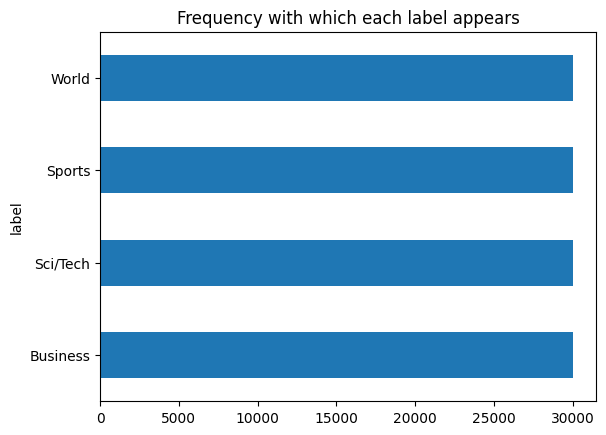

In [10]:
(
    dataset.select_columns('label')
        .to_pandas()
        .astype(str)['label']
        .map(id2label)
        .value_counts()
        .plot(kind="barh", title="Frequency with which each label appears")
);

In [12]:
def get_length_of_text(example):
    example['length_of_text'] = len(example['text'])
    return example

dataset = dataset.map(get_length_of_text)
dataset[:10]['length_of_text']

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

[144, 266, 232, 256, 234, 239, 215, 252, 414, 147]

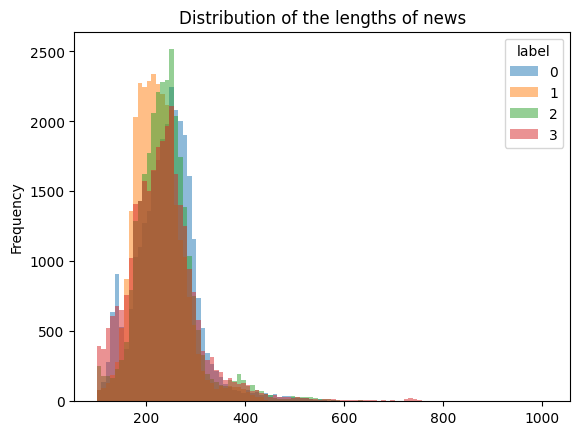

In [13]:
(
    dataset.select_columns(["label", "length_of_text"])
        .to_pandas()
        .pivot(columns='label', values='length_of_text')
        .plot.hist(bins=100, alpha=0.5, title="Distribution of the lengths of news")
);

## Tokenize and embed data using GPT-2

In [14]:
from transformers import AutoModel, AutoTokenizer
import torch

In [16]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

mps_device

device(type='mps')

In [19]:
%%time
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModel.from_pretrained('gpt2').to(mps_device)

CPU times: user 706 ms, sys: 746 ms, total: 1.45 s
Wall time: 695 ms


In [20]:
tokenizer.eos_token

'<|endoftext|>'

In [22]:
tokenizer.pad_token

In [23]:
tokenizer.pad_token = tokenizer.eos_token

In [25]:
text = "What does a cow use to do math? A cow-culator."
inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt").to(mps_device)
inputs

{'input_ids': tensor([[ 2061,   857,   257,  9875,   779,   284,   466, 10688,    30,   317,
          9875,    12,  3129,  1352,    13]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}

In [26]:
toks = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
toks

['What',
 'Ġdoes',
 'Ġa',
 'Ġcow',
 'Ġuse',
 'Ġto',
 'Ġdo',
 'Ġmath',
 '?',
 'ĠA',
 'Ġcow',
 '-',
 'cul',
 'ator',
 '.']

In [27]:
tokenizer.convert_tokens_to_string(toks)

'What does a cow use to do math? A cow-culator.'

In [28]:
tokenizer.vocab_size

50257

In [31]:
%%time
with torch.no_grad():
    embs = model(**inputs)

embs.last_hidden_state.size(), embs[0]

CPU times: user 44.9 ms, sys: 8.31 ms, total: 53.2 ms
Wall time: 54.6 ms


(torch.Size([1, 15, 768]),
 tensor([[[-0.1643,  0.0957, -0.2844,  ..., -0.1632, -0.0774, -0.2154],
          [ 0.0472,  0.2181,  0.0754,  ...,  0.0281,  0.2386, -0.0731],
          [-0.1410,  0.1957,  0.5674,  ..., -0.4050,  0.1199, -0.0043],
          ...,
          [ 0.0686,  0.2000,  0.2881,  ...,  0.2151, -0.5111, -0.2907],
          [-0.0662,  0.3934, -0.8001,  ...,  0.2597, -0.1465, -0.1695],
          [-0.1900, -0.2704, -0.3135,  ...,  0.3318, -0.4120, -0.0153]]],
        device='mps:0'))